In [10]:
import pandas
import numpy as np
import json
import csv

In [32]:
used_eids = []
with open("train_new.csv","r") as f:
    csvObj = csv.reader(f)
    for line in csvObj:
        used_eids.append(line[0])

with open("val_new.csv","r") as f:
    csvObj = csv.reader(f)
    for line in csvObj:
        used_eids.append(line[0])

testData = {}
with open("data_new.csv","r") as f:
    csvObj = csv.reader(f)
    for line in csvObj:
        orgCnt = {'Body':0,'Liver':0,'Cyst':0,'Lung':0,'Heart':0,'Spleen':0,'Aorta':0,'Kidney':0,'IVC':0}

        if line[0] not in used_eids:
            tempDict = {}
            for i in range(1,len(line)-1,5):
                tempDict["{}_{}".format(line[i],orgCnt[line[i]])] = list(map(int,[line[i+1],line[i+2],line[i+3],line[i+4]]))
                orgCnt[line[i]] += 1
            testData[line[0]] = tempDict


In [33]:
import matplotlib.pyplot as plt

def IoU(coords0,coords1):
    bM0 = np.zeros((288,384))
    bM1 = np.zeros((288,384))

    for i in range(288):
        for j in range(384):
            if i >= coords0[1] and i < coords0[3]:
                if j >= coords0[0] and j < coords0[2]:
                    bM0[i,j] = 1
            if i >= coords1[1] and i < coords1[3]:
                if j >= coords1[0] and j < coords1[2]:
                    bM1[i,j] = 1

    intersect = np.logical_and(bM0,bM1)
    union = np.logical_or(bM0,bM1)  

    iou = np.sum(intersect)/np.sum(union)
    return iou


iou = IoU([20, 20, 90, 90],[50, 50, 150, 150])
print(iou)

0.12030075187969924


In [34]:
with open("Biobank_Bounding_Boxes_2021_8_16.json","r") as f:
    networkOutput = json.load(f)

In [64]:
testEids = list(testData.keys())

metricDict = {}
for eid in testEids:
    metricDict[eid] = {}
    orgDict = networkOutput[eid]
    testDict = testData[eid]

    orgs = list(orgDict.keys())
    orgsGT = list(testDict.keys())

    orgsStripGT = [x[:-2] for x in orgsGT]
    for org in orgs:
        if orgDict[org][-1] > 0.1:
            if org[:-2] not in orgsStripGT:
                metricDict[eid][org] = 0.0
            else:
                maxIoU = 0.0
                for i in range(orgsStripGT.count(org[:-2])):
                    iou = IoU(orgDict[org],testDict["{}_{}".format(org[:-2],i)])
                    if iou >= maxIoU:
                        maxIoU = iou

                metricDict[eid][org] = iou

In [65]:
for eid in testEids:
    orgsIoU = list(metricDict[eid].keys())
    stripOrgs = [x[:-2] for x in orgsIoU]
    setOrgs = list(set(stripOrgs))
    tempDict = {}
    for org in setOrgs:
        # if org in ["Lung","Kidney","Cyst"]:
        #     pass
        # else:
        tempDict[org] = np.mean([metricDict[eid]["{}_{}".format(org,i)] for i in range(stripOrgs.count(org))])

    metricDict[eid] = tempDict

print(metricDict)

{'3941648_20204_2_0': {'Heart': 0.8653333333333333, 'Cyst': 0.0, 'Aorta': 0.7819063004846527, 'Lung': 0.34196621985064385, 'Kidney': 0.0, 'Liver': 0.8553191489361702, 'Body': 0.911830027800643}, '1014070_20204_2_0': {'IVC': 0.0, 'Aorta': 0.7155555555555555, 'Liver': 0.8444475890614498, 'Spleen': 0.8760265936644506, 'Body': 0.9669831294154354}, '1014104_20204_2_0': {'IVC': 0.6192660550458715, 'Aorta': 0.8308921438082557, 'Kidney': 0.0, 'Liver': 0.8944485183108312, 'Spleen': 0.9096301465457083, 'Body': 0.9581571428571428}, '1014221_20204_2_0': {'Heart': 0.0, 'IVC': 0.8902077151335311, 'Cyst': 0.0, 'Aorta': 0.7863247863247863, 'Lung': 0.0, 'Kidney': 0.0, 'Liver': 0.44691147167662965, 'Spleen': 0.8624911032028469, 'Body': 0.9151982515615492}, '1014254_20204_2_0': {'Liver': 0.9506043089858118, 'IVC': 0.0, 'Aorta': 0.7368421052631579, 'Body': 0.8861258190251331}, '1014453_20204_2_0': {'Heart': 0.0, 'IVC': 0.47619047619047616, 'Cyst': 0.0, 'Aorta': 0.7195767195767195, 'Kidney': 0.852882703777

In [66]:
df = pandas.DataFrame(metricDict)
df = df.T


In [67]:
df.describe()

,Heart,Cyst,Aorta,Lung,Kidney,Liver,Body,IVC,Spleen
count,32.000000,37.000000,56.000000,31.000000,20.000000,61.000000,64.000000,43.000000,47.000000
mean,0.314943,0.007066,0.797422,0.192252,0.171632,0.810252,0.931910,0.562906,0.654764
std,0.394651,0.042980,0.062078,0.232325,0.296865,0.227726,0.042393,0.323889,0.360509
min,0.000000,0.000000,0.658759,0.000000,0.000000,0.000000,0.682426,0.000000,0.000000
25%,0.000000,0.000000,0.754765,0.000000,0.000000,0.831870,0.911633,0.488095,0.530007
50%,0.000000,0.000000,0.794421,0.000000,0.000000,0.889269,0.943149,0.684564,0.834603
75%,0.786014,0.000000,0.828413,0.371770,0.271757,0.926834,0.955623,0.808628,0.900050
max,0.923109,0.261440,0.923077,0.931358,0.852883,0.987730,0.986280,0.890208,0.958719


## mean Average Precision

In [1]:
# Recall versus IoU curve
# Recall = TP/TP + FN

import pandas
import numpy as np
import json
import csv
import sys

In [2]:
used_eids = []
with open("train_new.csv","r") as f:
    csvObj = csv.reader(f)
    for line in csvObj:
        used_eids.append(line[0])

with open("val_new.csv","r") as f:
    csvObj = csv.reader(f)
    for line in csvObj:
        used_eids.append(line[0])

testData = {}
with open("data_new.csv","r") as f:
    csvObj = csv.reader(f)
    for line in csvObj:
        orgCnt = {'Body':0,'Liver':0,'Cyst':0,'Lung':0,'Heart':0,'Spleen':0,'Aorta':0,'Kidney':0,'IVC':0}

        if line[0] not in used_eids:
            tempDict = {}
            for i in range(1,len(line)-1,5):
                tempDict["{}_{}".format(line[i],orgCnt[line[i]])] = list(map(int,[line[i+1],line[i+2],line[i+3],line[i+4]]))
                orgCnt[line[i]] += 1
            testData[line[0]] = tempDict

In [5]:
len(testData.keys())

64

In [4]:
with open("Biobank_Bounding_Boxes_2021_8_16.json","r") as f:
    networkOutput = json.load(f)

In [9]:
def IoU(coords0,coords1):
    bM0 = np.zeros((288,384))
    bM1 = np.zeros((288,384))

    for i in range(288):
        for j in range(384):
            if i >= coords0[1] and i < coords0[3]:
                if j >= coords0[0] and j < coords0[2]:
                    bM0[i,j] = 1
            if i >= coords1[1] and i < coords1[3]:
                if j >= coords1[0] and j < coords1[2]:
                    bM1[i,j] = 1

    intersect = np.logical_and(bM0,bM1)
    union = np.logical_or(bM0,bM1)  

    iou = np.sum(intersect)/np.sum(union)
    return iou

In [68]:
testEids = list(testData.keys())
accCutOff = 0.5

iouDict = {}
for eid in testEids:
    iouDict[eid] = {}
    orgDict = networkOutput[eid]
    testDict = testData[eid]


    orgs = list(orgDict.keys())
    orgsGT = list(testDict.keys())

    for org in orgs:
        if orgDict[org][-1] < accCutOff:
            del orgDict[org]

    orgsStripGT = [x[:-2] for x in orgsGT]
    for org in orgs:
        cnt = orgsStripGT.count(org[:-2])
        if cnt:
            iou = [IoU(orgDict[org],testDict["{}_{}".format(org[:-2],i)]) for i in range(cnt)]
            iou = np.max(iou)
            iouDict[eid][org] = iou
    
        else:
            iouDict[eid][org] = 0.0

In [62]:
iouRange = np.arange(0,1,0.01)
iouRange = iouRange[1:]
# classes = ["Heart","Cyst","Aorta","Lung","Kidney","Liver","Body","IVC","Spleen"]
# recallCurves = {cl:np.zeros_like(iouRange) for cl in classes}
recallCurve = np.zeros_like(iouRange)

for i,iou in enumerate(iouRange):
    tp = 0
    fn = 0

    for eid in testEids:
        for org in iouDict[eid].keys():
            if iouDict[eid][org] >= iou:
                tp += 1
            else:
                fn += 1

    recallCurve[i] = tp/(tp+fn)

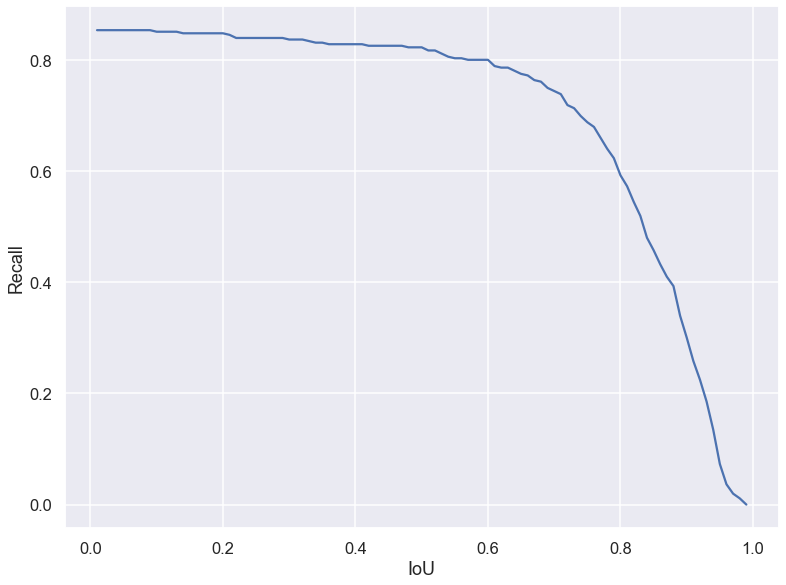

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

df = {"IoU":iouRange,"Recall":recallCurve,"Class":["Recall (All Classes)"]*iouRange.shape[0]}
df = pandas.DataFrame(df)

sns.set_context("talk")
sns.lineplot(data=df,x="IoU",y="Recall")
plt.show()


In [64]:
classes = ["Heart","Cyst","Aorta","Lung","Kidney","Liver","Body","IVC","Spleen"]
recallCurves = {cl:np.zeros_like(iouRange) for cl in classes}

for i,iou in enumerate(iouRange):
    for cl in classes:
        tp = 0
        fn = 0

        for eid in testEids:
            for org in iouDict[eid].keys():
                if org[:-2] == cl:
                    if iouDict[eid][org] >= iou:
                        tp += 1
                    else:
                        fn += 1

        recallCurves[cl][i] = tp/(tp+fn)

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

df = {"IoU":[],"Recall":[],"Class":[]}
for cl in classes:
    df["IoU"].extend(list(iouRange))
    df["Recall"].extend(list(recallCurves[cl]))
    df["Class"].extend([cl]*iouRange.shape[0])

df = pandas.DataFrame(df)
df

,IoU,Recall,Class
0,0.01,0.608696,Heart
1,0.02,0.608696,Heart
2,0.03,0.608696,Heart
3,0.04,0.608696,Heart
4,0.05,0.608696,Heart
...,...,...,...
886,0.95,0.021739,Spleen
887,0.96,0.000000,Spleen
888,0.97,0.000000,Spleen
889,0.98,0.000000,Spleen


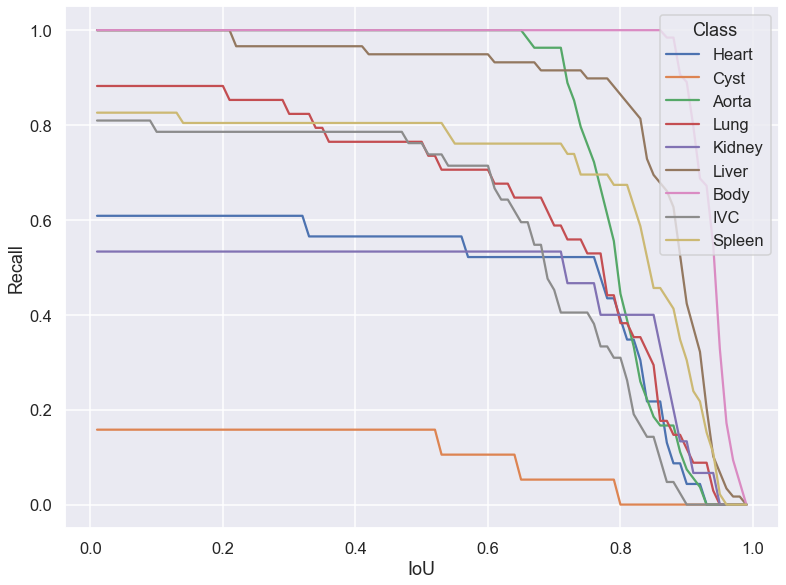

In [66]:
plt.rcParams["figure.figsize"] = [6.4*2,4.8*2]
sns.set_context("talk")
sns.lineplot(data=df,x="IoU",y="Recall",hue="Class")
plt.show()

In [103]:
import copy

metricDict = {}
for eid in testEids:
    metricDict[eid] = {}
    orgDict = networkOutput[eid]
    testDict = testData[eid]

    orgs = list(orgDict.keys())
    orgsGT = list(testDict.keys())

    orgsStripGT = [x[:-2] for x in orgsGT]
    notFoundOrgs = copy.deepcopy(orgsStripGT)

    for org in orgs:
        cnt = orgsStripGT.count(org[:-2])
        if cnt:
            try:
                notFoundOrgs.remove(org[:-2])
            except ValueError:
                pass # multiple pred of that class, i.e. lungs
            iou = [IoU(orgDict[org],testDict["{}_{}".format(org[:-2],i)]) for i in range(cnt)]
            iou = np.max(iou)
            metricDict[eid][org] = (iou,orgDict[org][-1])
        else:
            metricDict[eid][org] = (0.0,orgDict[org][-1])

    # for orgGT in notFoundOrgs:
    #     metricDict[eid][orgGT] = ("FN",0.0,0.0)


## PR Curve IoU = 0.9

In [117]:
# precision = tp/(tp+fp)
tempList = []
for eid in metricDict.keys():
    for org in metricDict[eid].keys():
        tempList.append({"Class":org[:-2],"IoU":metricDict[eid][org][0],"Confidence":metricDict[eid][org][1]})

df = pandas.DataFrame(tempList)

In [118]:
df

,Class,IoU,Confidence
0,Body,0.911830,0.999972
1,Lung,0.935716,0.999789
2,Lung,0.901334,0.999150
3,Heart,0.865333,0.998920
4,Aorta,0.781906,0.996653
...,...,...,...
351,Body,0.937637,0.999957
352,Lung,0.872743,0.999711
353,Lung,0.852155,0.999502
354,Heart,0.835358,0.998813


In [119]:
df = df.sort_values(by="Confidence",ascending=False)
df

,Class,IoU,Confidence
160,Liver,0.987730,0.999992
42,Liver,0.896592,0.999986
108,Liver,0.879413,0.999983
341,Body,0.982575,0.999979
74,Body,0.953310,0.999978
...,...,...,...
84,Cyst,0.000000,0.529882
153,Heart,0.000000,0.525347
274,Spleen,0.000000,0.522846
325,Spleen,0.000000,0.515532


In [120]:
df["TP"] = 0
df["FP"] = 0
df["Acc TP"] = 0
df["Acc FP"] = 0
df["Precision"] = 0.0
df["Recall"] = 0.0

df

,Class,IoU,Confidence,TP,FP,Acc TP,Acc FP,Precision,Recall
160,Liver,0.987730,0.999992,0,0,0,0,0.0,0.0
42,Liver,0.896592,0.999986,0,0,0,0,0.0,0.0
108,Liver,0.879413,0.999983,0,0,0,0,0.0,0.0
341,Body,0.982575,0.999979,0,0,0,0,0.0,0.0
74,Body,0.953310,0.999978,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
84,Cyst,0.000000,0.529882,0,0,0,0,0.0,0.0
153,Heart,0.000000,0.525347,0,0,0,0,0.0,0.0
274,Spleen,0.000000,0.522846,0,0,0,0,0.0,0.0
325,Spleen,0.000000,0.515532,0,0,0,0,0.0,0.0


In [121]:
iouCutoff = 0.9
for i,j in df.iterrows():
    if j["IoU"] >= iouCutoff:
        df.at[i,"TP"] = 1
    else:
        df.at[i,"FP"] = 1

df

,Class,IoU,Confidence,TP,FP,Acc TP,Acc FP,Precision,Recall
160,Liver,0.987730,0.999992,1,0,0,0,0.0,0.0
42,Liver,0.896592,0.999986,0,1,0,0,0.0,0.0
108,Liver,0.879413,0.999983,0,1,0,0,0.0,0.0
341,Body,0.982575,0.999979,1,0,0,0,0.0,0.0
74,Body,0.953310,0.999978,1,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
84,Cyst,0.000000,0.529882,0,1,0,0,0.0,0.0
153,Heart,0.000000,0.525347,0,1,0,0,0.0,0.0
274,Spleen,0.000000,0.522846,0,1,0,0,0.0,0.0
325,Spleen,0.000000,0.515532,0,1,0,0,0.0,0.0


In [122]:
lastI = 0
first = True
for i,j in df.iterrows():
    if first:
        df.at[i,"Acc TP"] = df.at[i,"TP"]
        df.at[i,"Acc FP"] = df.at[i,"FP"]
        lastI = i
        first = False
    else:
        df.at[i,"Acc TP"] = df.at[lastI,"Acc TP"] + df.at[i,"TP"]
        df.at[i,"Acc FP"] = df.at[lastI,"Acc FP"] + df.at[i,"FP"]
        lastI = i
df

,Class,IoU,Confidence,TP,FP,Acc TP,Acc FP,Precision,Recall
160,Liver,0.987730,0.999992,1,0,1,0,0.0,0.0
42,Liver,0.896592,0.999986,0,1,1,1,0.0,0.0
108,Liver,0.879413,0.999983,0,1,1,2,0.0,0.0
341,Body,0.982575,0.999979,1,0,2,2,0.0,0.0
74,Body,0.953310,0.999978,1,0,3,2,0.0,0.0
...,...,...,...,...,...,...,...,...,...
84,Cyst,0.000000,0.529882,0,1,107,245,0.0,0.0
153,Heart,0.000000,0.525347,0,1,107,246,0.0,0.0
274,Spleen,0.000000,0.522846,0,1,107,247,0.0,0.0
325,Spleen,0.000000,0.515532,0,1,107,248,0.0,0.0


In [124]:
numRois = 0
for eid in testData.keys():
    numRois += len(testData[eid].keys())

for i,j in df.iterrows():
    df.at[i,"Precision"] = df.at[i,"Acc TP"]/(df.at[i,"Acc FP"] + df.at[i,"Acc TP"])
    df.at[i,"Recall"] = df.at[i,"Acc TP"]/numRois

df

,Class,IoU,Confidence,TP,FP,Acc TP,Acc FP,Precision,Recall
160,Liver,0.987730,0.999992,1,0,1,0,1.000000,0.003021
42,Liver,0.896592,0.999986,0,1,1,1,0.500000,0.003021
108,Liver,0.879413,0.999983,0,1,1,2,0.333333,0.003021
341,Body,0.982575,0.999979,1,0,2,2,0.500000,0.006042
74,Body,0.953310,0.999978,1,0,3,2,0.600000,0.009063
...,...,...,...,...,...,...,...,...,...
84,Cyst,0.000000,0.529882,0,1,107,245,0.303977,0.323263
153,Heart,0.000000,0.525347,0,1,107,246,0.303116,0.323263
274,Spleen,0.000000,0.522846,0,1,107,247,0.302260,0.323263
325,Spleen,0.000000,0.515532,0,1,107,248,0.301408,0.323263


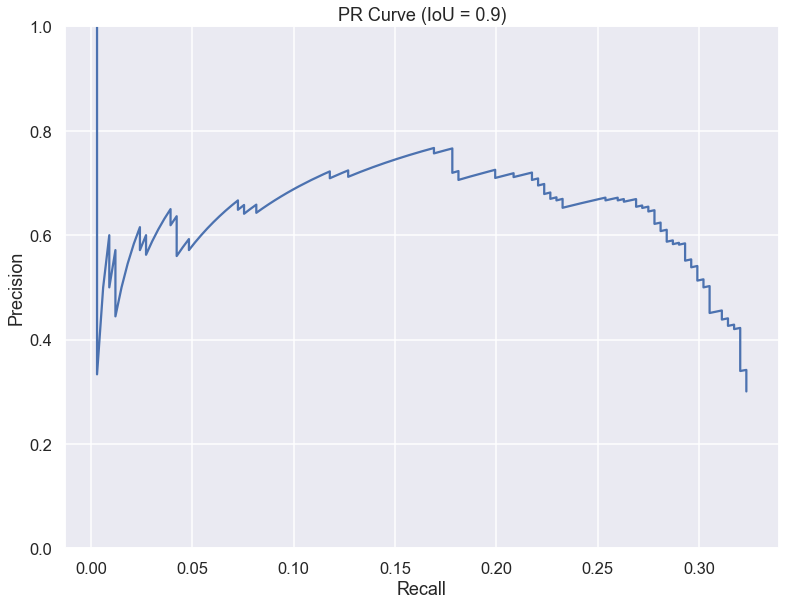

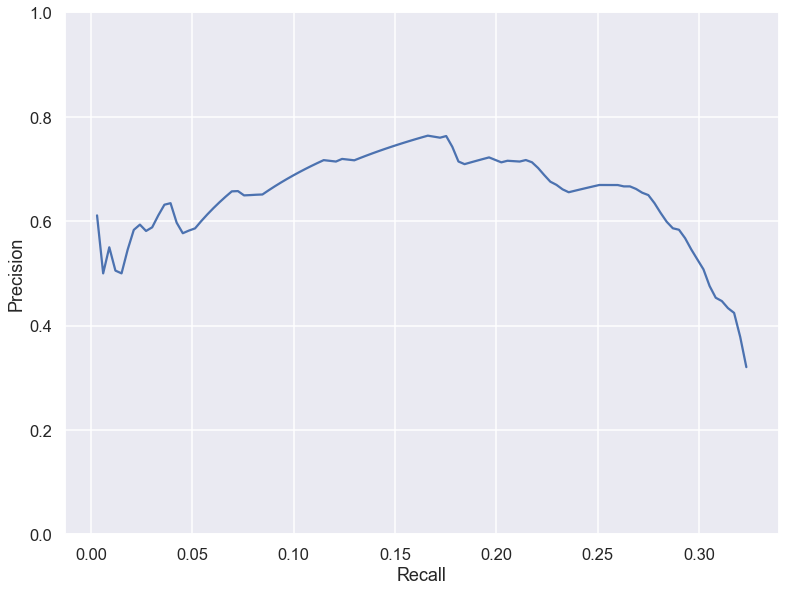

In [135]:
plt.title("PR Curve (IoU = 0.9)")
plt.plot(df["Recall"],df["Precision"])
plt.ylim([0,1.0])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

sns.lineplot(data=df,x = "Recall",y = "Precision", ci=None)
plt.ylim([0,1.0])
plt.show()

## PR Curve IoU = 0.5

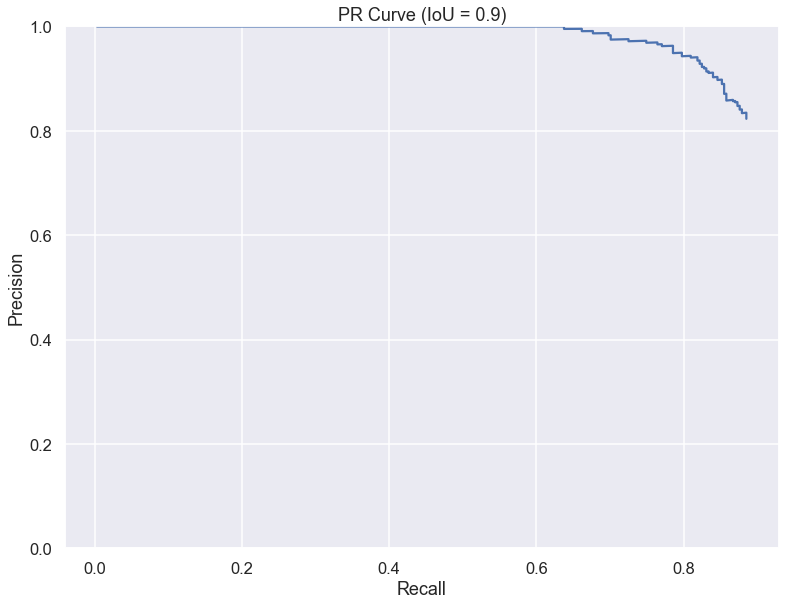

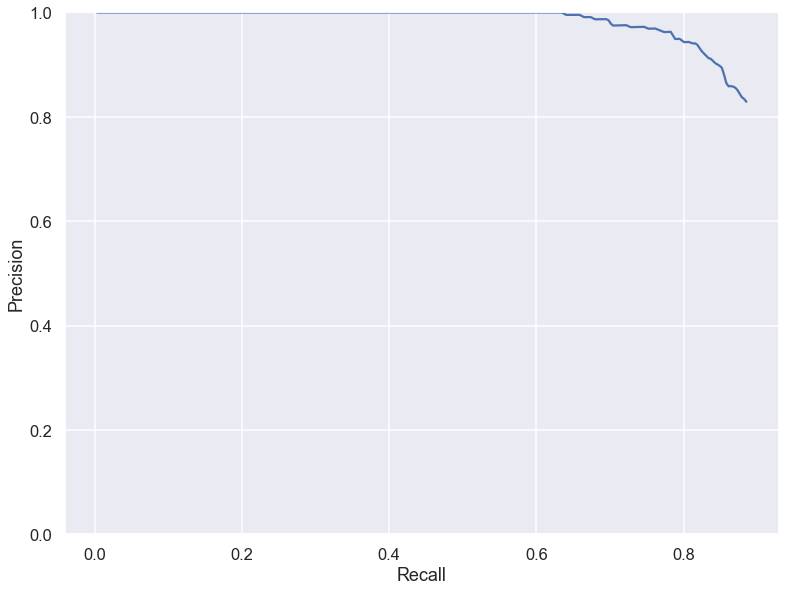

In [136]:
# precision = tp/(tp+fp)
iouCutoff = 0.5

tempList = []
for eid in metricDict.keys():
    for org in metricDict[eid].keys():
        tempList.append({"Class":org[:-2],"IoU":metricDict[eid][org][0],"Confidence":metricDict[eid][org][1]})

df = pandas.DataFrame(tempList)
df = df.sort_values(by="Confidence",ascending=False)

df["TP"] = 0
df["FP"] = 0
df["Acc TP"] = 0
df["Acc FP"] = 0
df["Precision"] = 0.0
df["Recall"] = 0.0

for i,j in df.iterrows():
    if j["IoU"] >= iouCutoff:
        df.at[i,"TP"] = 1
    else:
        df.at[i,"FP"] = 1

lastI = 0
first = True
for i,j in df.iterrows():
    if first:
        df.at[i,"Acc TP"] = df.at[i,"TP"]
        df.at[i,"Acc FP"] = df.at[i,"FP"]
        lastI = i
        first = False
    else:
        df.at[i,"Acc TP"] = df.at[lastI,"Acc TP"] + df.at[i,"TP"]
        df.at[i,"Acc FP"] = df.at[lastI,"Acc FP"] + df.at[i,"FP"]
        lastI = i

numRois = 0
for eid in testData.keys():
    numRois += len(testData[eid].keys())

for i,j in df.iterrows():
    df.at[i,"Precision"] = df.at[i,"Acc TP"]/(df.at[i,"Acc FP"] + df.at[i,"Acc TP"])
    df.at[i,"Recall"] = df.at[i,"Acc TP"]/numRois

plt.title("PR Curve (IoU = 0.5)")
plt.plot(df["Recall"],df["Precision"])
plt.ylim([0,1.0])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

sns.lineplot(data=df,x = "Recall",y = "Precision", ci=None)
plt.ylim([0,1.0])
plt.show()

0.8695429603481863
0.8419690042060872
0.776048831273258
0.587003875793071
0.20767345567869844


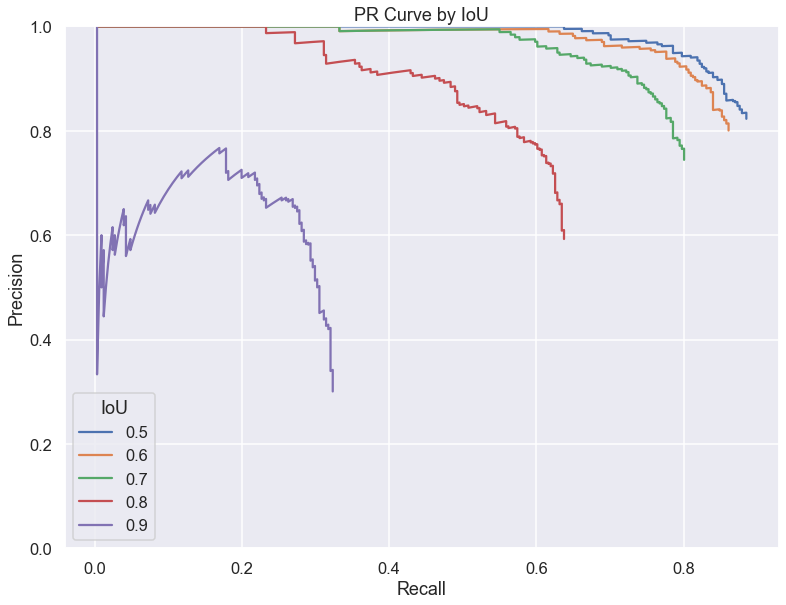

In [166]:
# precision = tp/(tp+fp)
# AP = sum((Rn - Rn-1)Pn)
from sklearn.metrics import auc

iouCutoffRange = np.arange(0.5,1.0,0.1)
plt.figure()
for iouCutoff in iouCutoffRange:
    tempList = []
    for eid in metricDict.keys():
        for org in metricDict[eid].keys():
            tempList.append({"Class":org[:-2],"IoU":metricDict[eid][org][0],"Confidence":metricDict[eid][org][1]})

    df = pandas.DataFrame(tempList)
    df = df.sort_values(by="Confidence",ascending=False)

    df["TP"] = 0
    df["FP"] = 0
    df["Acc TP"] = 0
    df["Acc FP"] = 0
    df["Precision"] = 0.0
    df["Recall"] = 0.0

    for i,j in df.iterrows():
        if j["IoU"] >= iouCutoff:
            df.at[i,"TP"] = 1
        else:
            df.at[i,"FP"] = 1

    lastI = 0
    first = True
    for i,j in df.iterrows():
        if first:
            df.at[i,"Acc TP"] = df.at[i,"TP"]
            df.at[i,"Acc FP"] = df.at[i,"FP"]
            lastI = i
            first = False
        else:
            df.at[i,"Acc TP"] = df.at[lastI,"Acc TP"] + df.at[i,"TP"]
            df.at[i,"Acc FP"] = df.at[lastI,"Acc FP"] + df.at[i,"FP"]
            lastI = i

    numRois = 0
    for eid in testData.keys():
        numRois += len(testData[eid].keys())

    for i,j in df.iterrows():
        df.at[i,"Precision"] = df.at[i,"Acc TP"]/(df.at[i,"Acc FP"] + df.at[i,"Acc TP"])
        df.at[i,"Recall"] = df.at[i,"Acc TP"]/numRois

    prec = df["Precision"].to_numpy()
    recall = df["Recall"].to_numpy()

    AP = auc(recall,prec)
    print(AP)

    plt.plot(df["Recall"],df["Precision"],label="{:.1f}".format(iouCutoff))

plt.ylim([0,1.0])
plt.legend(title="IoU")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve by IoU")

plt.show()

## PR Curve by class

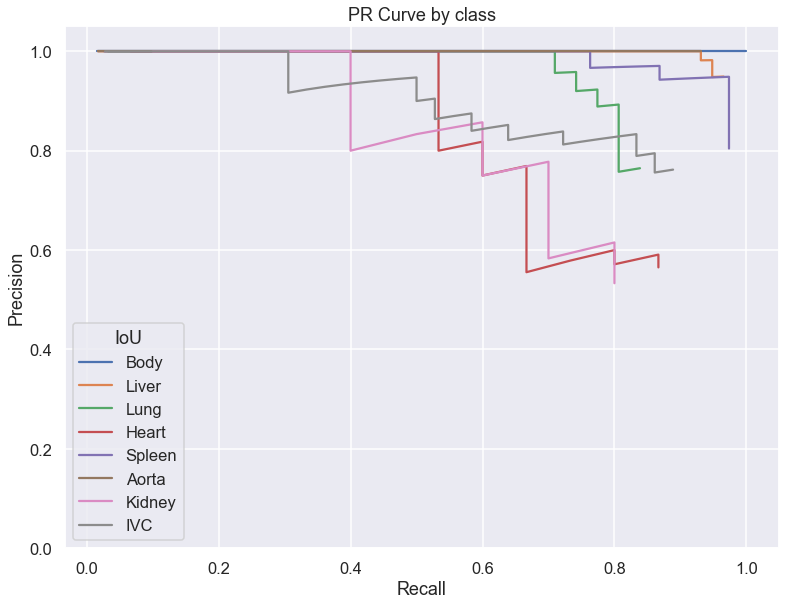

{'Body': 0.984375, 'Liver': 0.9470809434776112, 'Lung': 0.7913219301163779, 'Heart': 0.6871066847382638, 'Spleen': 0.9383779661418896, 'Aorta': 0.9137931034482759, 'Kidney': 0.6025152625152626, 'IVC': 0.7835785043990011}
0.8310186743545853


In [165]:
# precision = tp/(tp+fp)
# AP = sum((Rn - Rn-1)Pn)
from sklearn.metrics import auc

plt.figure()
iouCutoff = 0.5
organs = ['Body','Liver','Lung','Heart','Spleen','Aorta','Kidney','IVC',"Cyst"] # 'Cyst'

tempList = []
for eid in metricDict.keys():
    for org in metricDict[eid].keys():
        tempList.append({"Class":org[:-2],"IoU":metricDict[eid][org][0],"Confidence":metricDict[eid][org][1]})

mAP = {}
for org in organs:
    df = pandas.DataFrame(tempList)
    df = df.sort_values(by="Confidence",ascending=False)
    df = df[df["Class"] == org]

    df["TP"] = 0
    df["FP"] = 0
    df["Acc TP"] = 0
    df["Acc FP"] = 0
    df["Precision"] = 0.0
    df["Recall"] = 0.0

    for i,j in df.iterrows():
        if j["IoU"] >= iouCutoff:
            df.at[i,"TP"] = 1
        else:
            df.at[i,"FP"] = 1

    lastI = 0
    first = True
    for i,j in df.iterrows():
        if first:
            df.at[i,"Acc TP"] = df.at[i,"TP"]
            df.at[i,"Acc FP"] = df.at[i,"FP"]
            lastI = i
            first = False
        else:
            df.at[i,"Acc TP"] = df.at[lastI,"Acc TP"] + df.at[i,"TP"]
            df.at[i,"Acc FP"] = df.at[lastI,"Acc FP"] + df.at[i,"FP"]
            lastI = i

    numRois = 0
    for eid in testData.keys():
        numRois += len([x for x in testData[eid].keys() if org in x])
    
    for i,j in df.iterrows():
        df.at[i,"Precision"] = df.at[i,"Acc TP"]/(df.at[i,"Acc FP"] + df.at[i,"Acc TP"])
        df.at[i,"Recall"] = df.at[i,"Acc TP"]/numRois

    prec = df["Precision"].to_numpy()
    recall = df["Recall"].to_numpy()

    mAP[org] = auc(recall,prec)

    plt.plot(df["Recall"],df["Precision"],label="{}".format(org))

plt.ylim([0,1.05])
plt.legend(title="IoU")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve by class")

plt.show()

print(mAP)
print(np.mean(list(mAP.values())))

In [172]:
AP = np.array(list(mAP.values()))
AP *= 100

regions = pandas.DataFrame({"Organs":list(mAP.keys()),"AP (%)":AP})
regions.to_latex("average_precision.tex")